In [1]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [2]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [4]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [28]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_Johnson.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [29]:
df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                |
|Britain will buy potential COVID19 vaccines from US drugmakers Johnson amp Johnson  Novavax Inc  companies          |
|EU concludes discussions with Janssen Pharmaceutica subsidiary of US Johnson amp Johnson for supply of CovidVaccine |
|UK follows EU in signing deal for a separate 90m doses of US Johnson amp Johnson CovidVaccine                       |
|BBC report omits  m "                                                                                               |
|Johnson amp Johnson is beginning a huge final s

In [30]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [31]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [32]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|                text|                text|
|Britain will buy ...|Britain will buy ...|
|EU concludes disc...|EU concludes disc...|
|UK follows EU in ...|UK follows EU in ...|
|BBC report omits ...|BBC report omits  m |
|Johnson amp Johns...|Johnson amp Johns...|
|Johnson amp Johns...|Johnson amp Johns...|
|Johnson amp Johns...|Johnson amp Johns...|
|COVID19 Vaccine C...|COVID19 Vaccine C...|
|Do you really wan...|Do you really wan...|
|  Forget Trump  This|  Forget Trump  This|
|Johnson amp Johns...|Johnson amp Johns...|
| Johnson amp John...| Johnson amp John...|
|Johnson amp Johns...|Johnson amp Johns...|
|Pharma giant John...|Pharma giant John...|
|Johnson amp Johns...|Johnson amp Johns...|
|Johnson amp Johns...|Johnson amp Johns...|
|                   "|                    |
|Johnson amp Johns...|Johnson amp Johns...|
|                   "|          

In [33]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

551

In [34]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [35]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|
|Britain will buy ...|Britain will buy ...|[britain, will, b...|[britain, buy, po...|
|EU concludes disc...|EU concludes disc...|[eu, concludes, d...|[eu, concludes, d...|
|UK follows EU in ...|UK follows EU in ...|[uk, follows, eu,...|[uk, follows, eu,...|
|BBC report omits ...|BBC report omits  m |[bbc, report, omi...|[bbc, report, omi...|
|Johnson amp Johns...|Johnson amp Johns...|[johnson, amp, jo...|[johnson, amp, jo...|
|Johnson amp Johns...|Johnson amp Johns...|[johnson, amp, jo...|[johnson, amp, jo...|
|Johnson amp Johns...|Johnson amp Johns...|[johnson, amp, jo...|[johnson, amp, jo...|
|COVID19 Vaccine C...|COVID19 Vaccine C...|[covid19, v

In [51]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [52]:
model.getVectors().show(truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [53]:
vecs = model.getVectors()

In [54]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [55]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('works', 0.9650161266326904),
 ('latestage', 0.9646429419517517),
 ('clinical', 0.9415749907493591),
 ('onedose', 0.9369809031486511),
 ('oneshot', 0.929832398891449),
 ('cidate', 0.9051157832145691),
 ('canada', 0.8857119679450989),
 ('eu', 0.8846244215965271),
 ('strong', 0.8846173882484436),
 ('coronavirus', 0.8809229135513306),
 ('third', 0.867002546787262),
 ('protection', 0.8499121069908142),
 ('covid', 0.8414846658706665),
 ('companies', 0.8358078598976135),
 ('read', 0.8271632790565491),
 ('approval', 0.8186277747154236),
 ('singleshot', 0.8094496726989746),
 ('pauses', 0.8092420101165771),
 ('single', 0.7903541326522827),
 ('johnsons', 0.7779462337493896)]

In [56]:
w2v = model.transform(final_df)

In [57]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|[0.0,0.0,0.0,0.0,...|
|Britain will buy ...|Britain will buy ...|[britain, will, b...|[britain, buy, po...|[0.01033115925577...|
|EU concludes disc...|EU concludes disc...|[eu, concludes, d...|[eu, concludes, d...|[0.00275968664209...|
|UK follows EU in ...|UK follows EU in ...|[uk, follows, eu,...|[uk, follows, eu,...|[9.02128620789601...|
|BBC report omits ...|BBC report omits  m |[bbc, report, omi...|[bbc, report, omi...|[0.00853535830974...|
|Johnson amp Johns...|Johnson amp Johns...|[johnson, amp, jo...|[johnson, amp, jo...|[0.00500508851837...|
|Johnson amp Johns...|Johnson amp Joh

In [58]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [59]:
w2v_clustering.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [60]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [61]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                |features                                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(12).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [63]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.3351784389056992


In [64]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.363108
3,5,0.505546
4,6,0.437019
5,7,0.457042
6,8,0.403291
7,9,0.440553
8,10,0.340505
9,11,0.295716


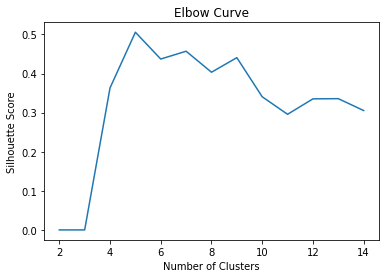

In [65]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|                text|[0.0,0.0,0.0,0.0,...|        12|
|Pfizer is looking...|[0.04806540875625...|         3|
|Pfizers COVID vac...|[0.50025610368800...|         2|
|pfizers¬†covidvac...|[0.0,0.0,0.0,0.0,...|        12|
|For more informat...|[0.05960954204242...|         3|
|CovidVaccine COVI...|[-0.2550230467739...|        12|
|One of  vaccines ...|[0.04421593534635...|         3|
|NVAX beats BNTX P...|[0.00450288041716...|         3|
|Though Pfizer use...|[-0.0505790027682...|        12|
|Phase III data on...|[0.15676166328007...|         3|
|PfizerBioNTech CO...|[0.06359193763152...|         3|
|So psyched  be pa...|[-0.0040071643692...|         3|
|BioNTech cofounde...|[0.04405919407265...|         3|
|Read  Aug 21 News...|[0.10173814900769...|         3|
|Read Carole Sians...|[0.04725395730151...|         3|
|PfizerBio

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                            |features                                                                                                                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------